# Assignment 11.1 — What Drives the Price of a Car?
This notebook loads the used-car dataset, performs data cleaning, runs EDA visualizations, builds multiple regression models with cross-validation and grid search, and interprets coefficients.


## 0) Setup + Load Data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.compose import TransformedTargetRegressor

sns.set_context("talk")
sns.set_style("whitegrid")

df = pd.read_csv("vehicles.csv")

print("Shape:", df.shape)
df.head()


Shape: (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


## 1) Data Understanding (quick audit)

In [6]:
df.info()

missing = (df.isna().mean().sort_values(ascending=False) * 100).round(1)
display(pd.DataFrame({"missing_%": missing, "dtype": df.dtypes.astype(str)}).head(25))

if "price" in df.columns:
    display(df["price"].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

,missing_%,dtype
VIN,37.7,object
condition,40.8,object
cylinders,41.6,object
drive,30.6,object
fuel,0.7,object
id,0.0,int64
manufacturer,4.1,object
model,1.2,object
odometer,1.0,float64
paint_color,30.5,object


count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64

## 2) Data Preparation (cleaning + realistic filters)
The dataset commonly contains outliers (0 price, very large prices, invalid year/odometer). These filters are designed to remove clearly unrealistic records and stabilize modeling.

In [7]:
df_clean = df.copy()

# Ensure numeric columns are numeric (coerce errors -> NaN)
for col in ["price", "year", "odometer"]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Drop rows missing target
df_clean = df_clean.dropna(subset=["price"])

# Remove clearly invalid / extreme values (adjust if your instructor expects different thresholds)
df_clean = df_clean[
    (df_clean["price"] >= 500) & (df_clean["price"] <= 200000) &
    (df_clean["year"] >= 1990) & (df_clean["year"] <= 2025) &
    (df_clean["odometer"].isna() | ((df_clean["odometer"] >= 0) & (df_clean["odometer"] <= 500000)))
].copy()

print("Before:", df.shape, "After:", df_clean.shape)

# Log-transform target (useful for visualization and more stable modeling)
df_clean["log_price"] = np.log1p(df_clean["price"])
df_clean[["price", "log_price"]].describe()


Before: (426880, 18) After: (370822, 18)


,price,log_price
count,370822.000000,370822.000000
mean,19355.351133,9.540194
std,14870.255121,0.899669
min,500.000000,6.216606
25%,7900.000000,8.974745
50%,15990.000000,9.679781
75%,27990.000000,10.239638
max,200000.000000,12.206078


## 3) Visualizations (continuous + categorical)

### 3.1 Price distribution (raw + log)

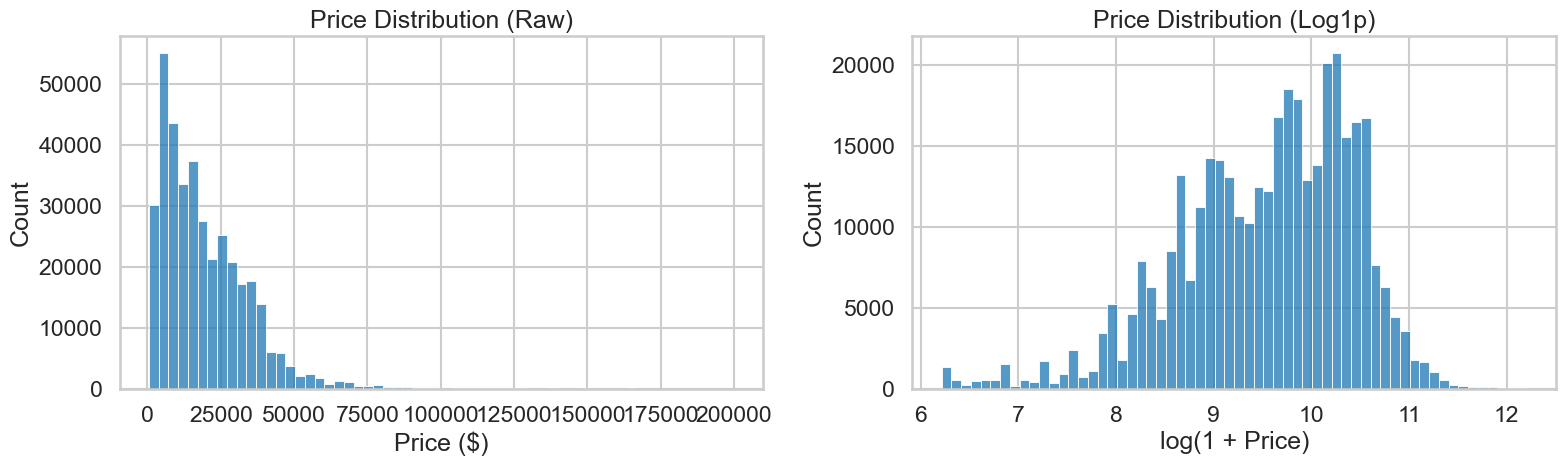

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df_clean["price"], bins=60, ax=ax[0])
ax[0].set_title("Price Distribution (Raw)")
ax[0].set_xlabel("Price ($)")

sns.histplot(df_clean["log_price"], bins=60, ax=ax[1])
ax[1].set_title("Price Distribution (Log1p)")
ax[1].set_xlabel("log(1 + Price)")

plt.tight_layout()
plt.show()


### 3.2 Price vs Year (scatter + trend)

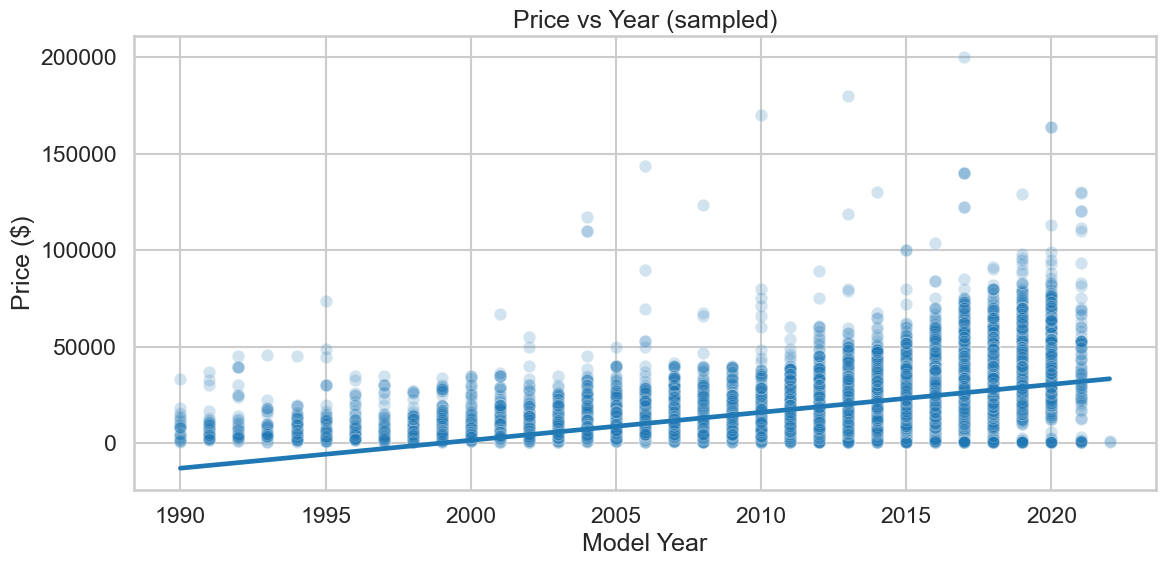

In [9]:
plt.figure(figsize=(12, 6))
sample = df_clean.sample(min(20000, len(df_clean)), random_state=42)

sns.scatterplot(data=sample, x="year", y="price", alpha=0.2)
sns.regplot(data=sample, x="year", y="price", scatter=False)
plt.title("Price vs Year (sampled)")
plt.xlabel("Model Year")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()


### 3.3 Log(Price) vs Odometer (scatter + trend)

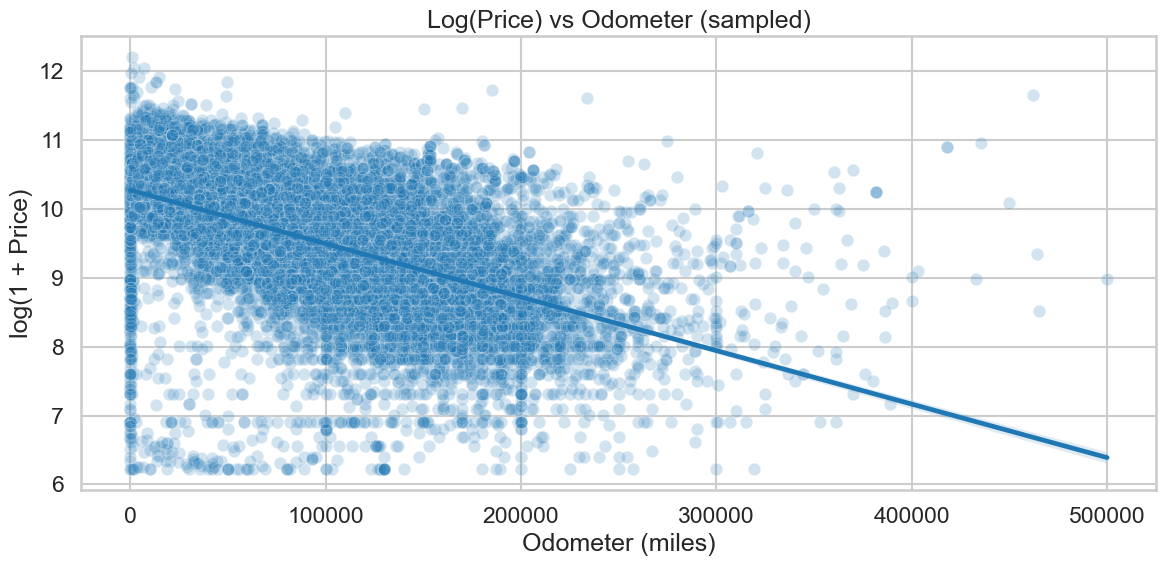

In [10]:
plt.figure(figsize=(12, 6))
sample = df_clean.dropna(subset=["odometer"]).sample(
    min(20000, df_clean["odometer"].notna().sum()),
    random_state=42
)

sns.scatterplot(data=sample, x="odometer", y="log_price", alpha=0.2)
sns.regplot(data=sample, x="odometer", y="log_price", scatter=False)
plt.title("Log(Price) vs Odometer (sampled)")
plt.xlabel("Odometer (miles)")
plt.ylabel("log(1 + Price)")
plt.tight_layout()
plt.show()


### 3.4 Categorical boxplots (top N categories for readability)

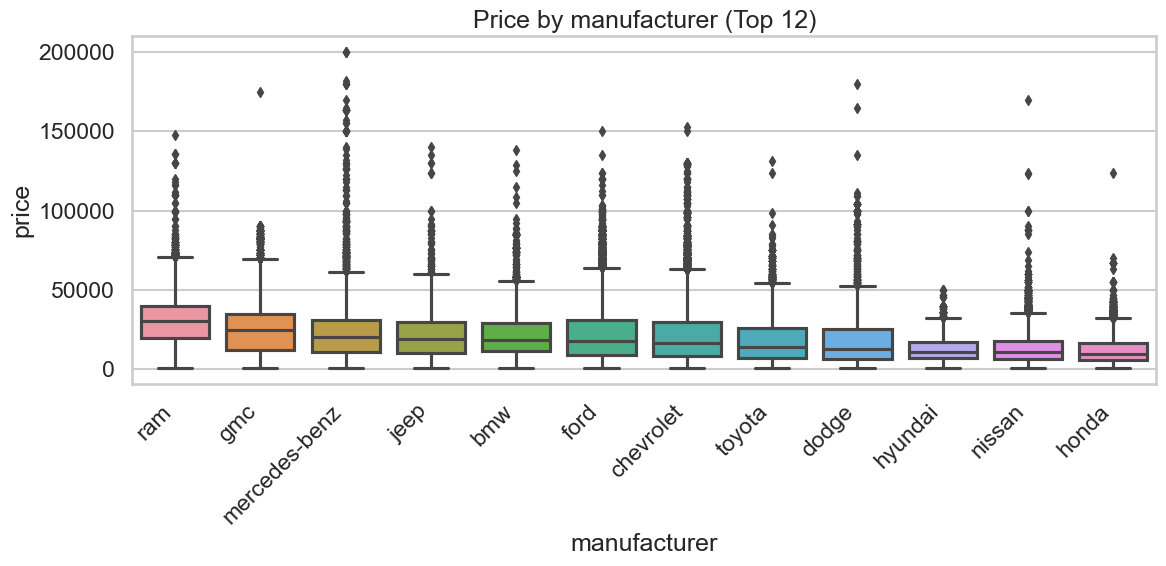

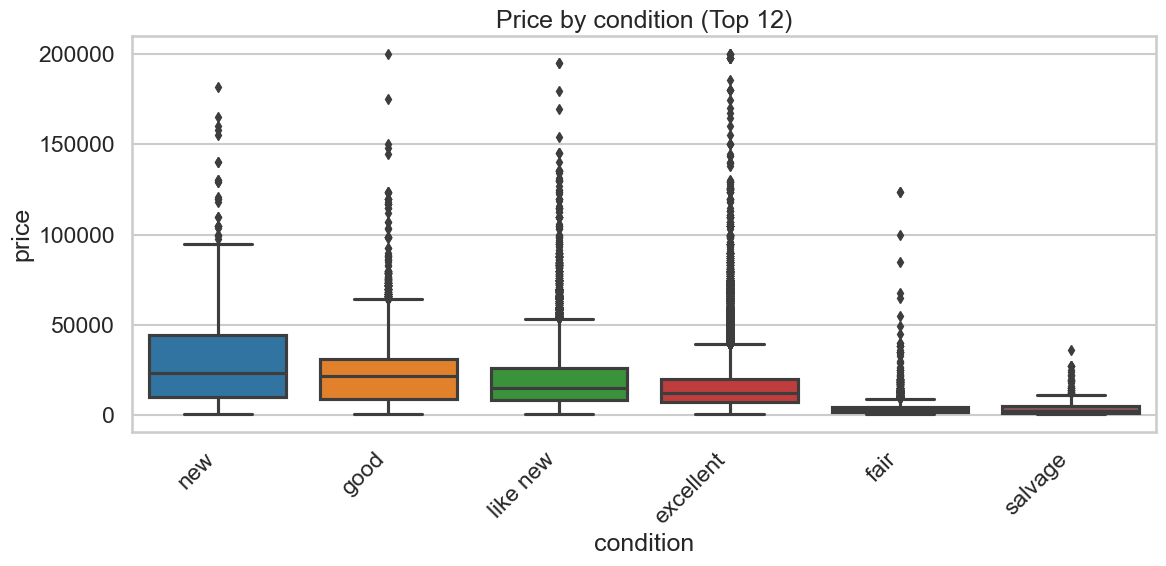

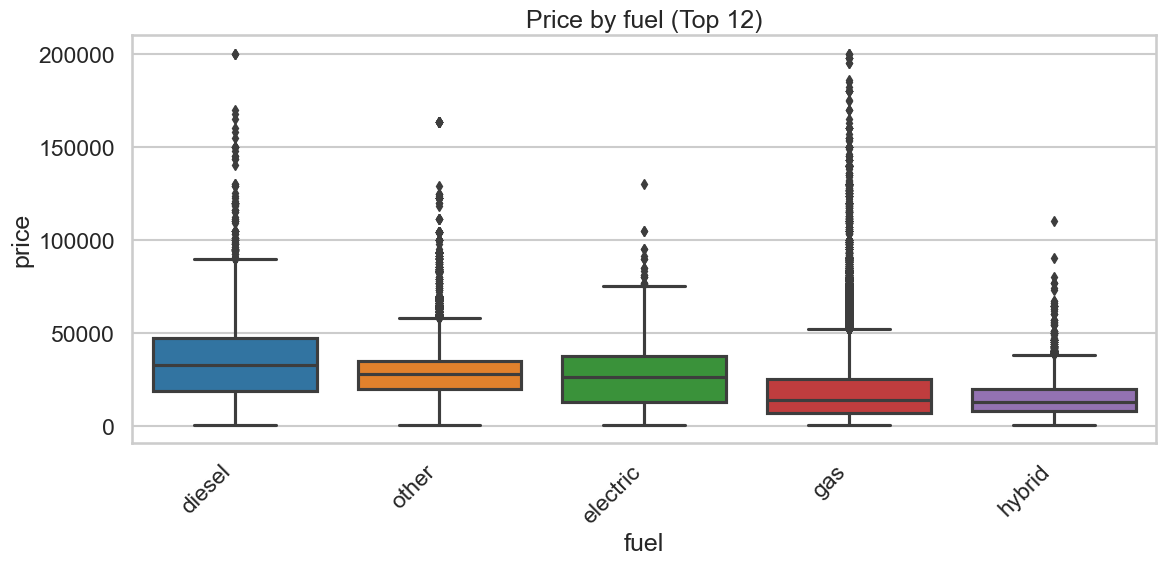

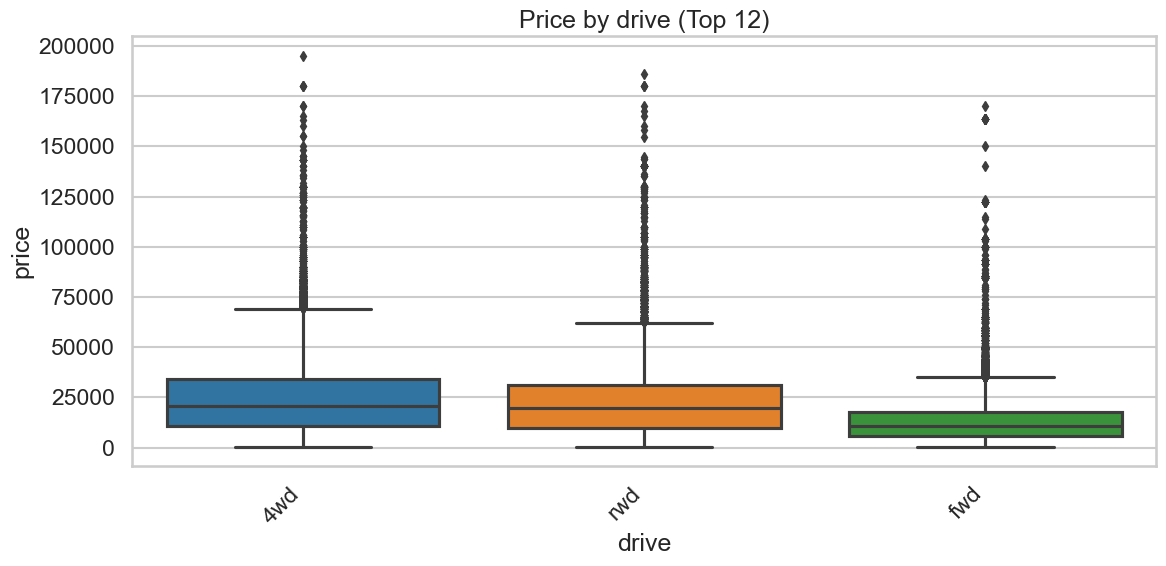

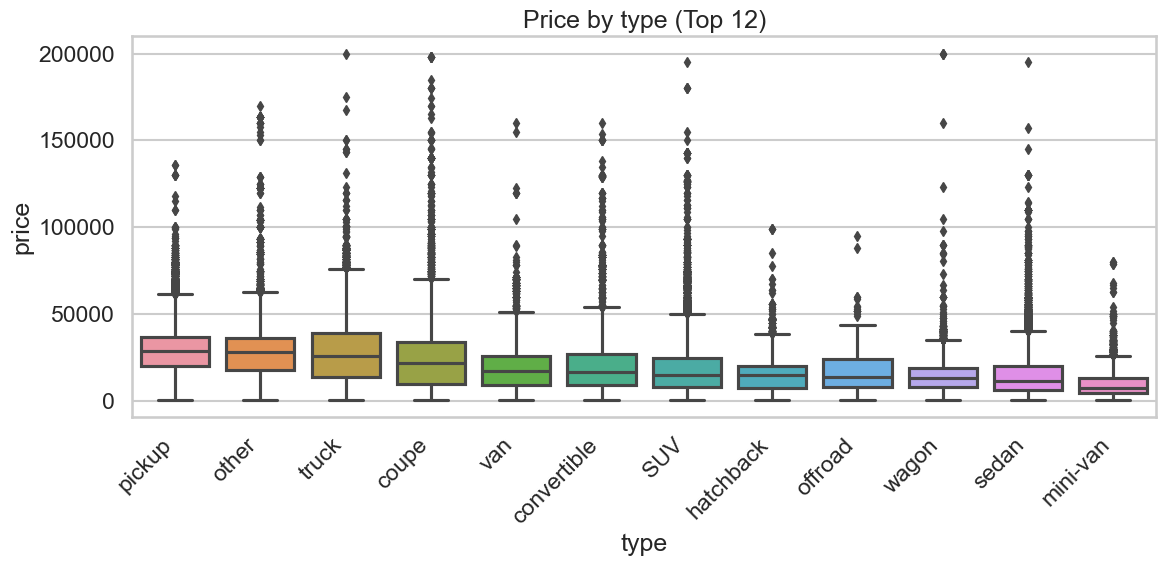

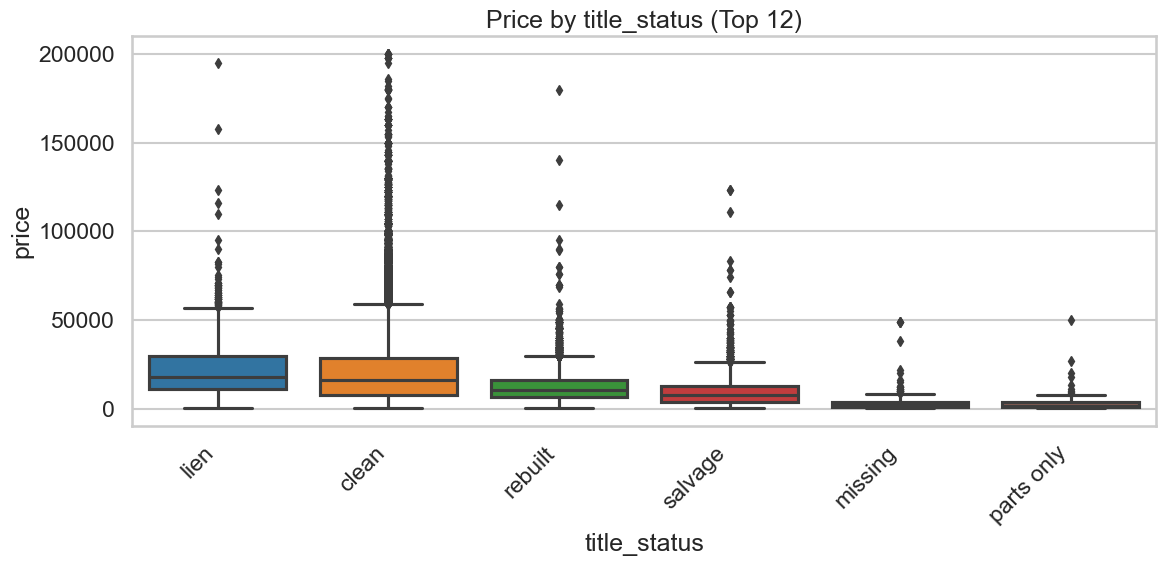

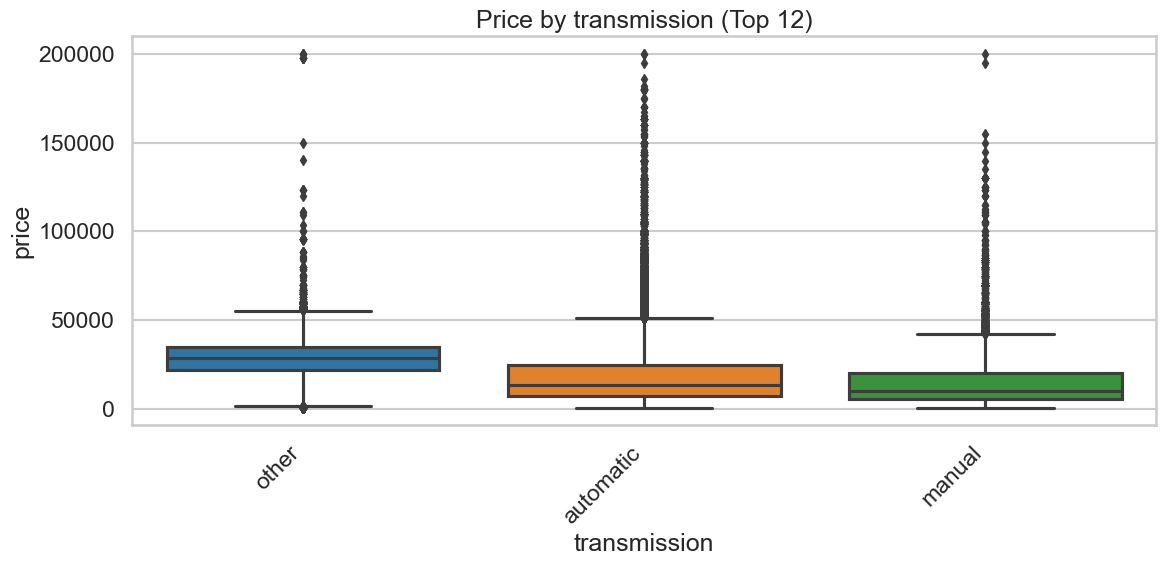

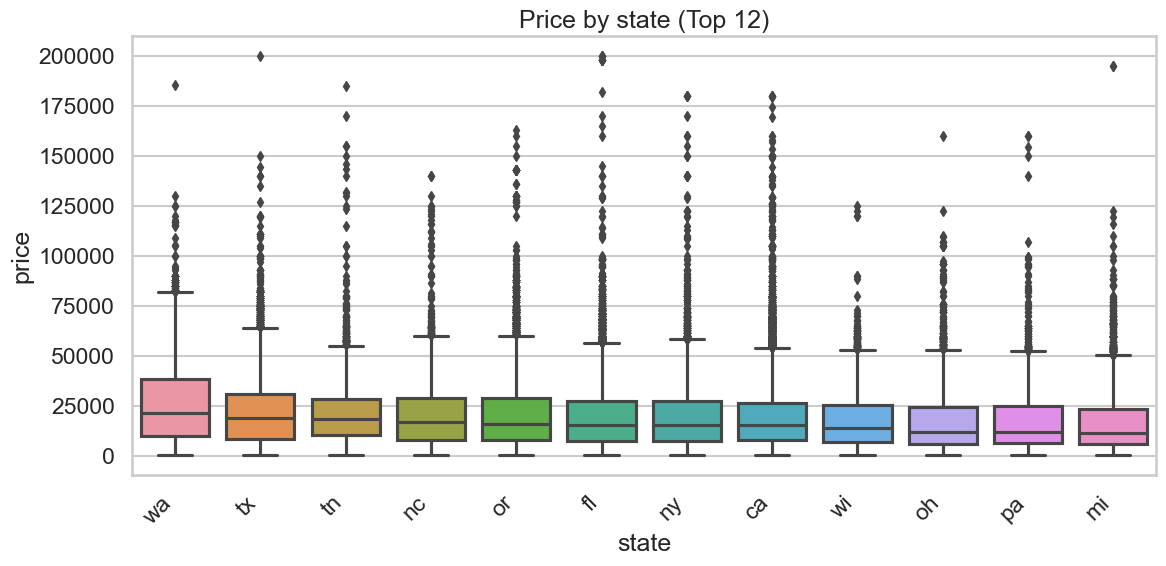

In [11]:
def plot_top_categories(df, cat_col, target_col="price", top_n=12):
    tmp = df.dropna(subset=[cat_col]).copy()
    top = tmp[cat_col].value_counts().head(top_n).index
    tmp = tmp[tmp[cat_col].isin(top)]

    order = (tmp.groupby(cat_col)[target_col].median().sort_values(ascending=False)).index

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=tmp, x=cat_col, y=target_col, order=order)
    plt.title(f"{target_col.title()} by {cat_col} (Top {top_n})")
    plt.xlabel(cat_col)
    plt.ylabel(target_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for col in ["manufacturer", "condition", "fuel", "drive", "type", "title_status", "transmission", "state"]:
    if col in df_clean.columns:
        plot_top_categories(df_clean, col, target_col="price", top_n=12)


### 3.5 Correlation heatmap (numeric features)

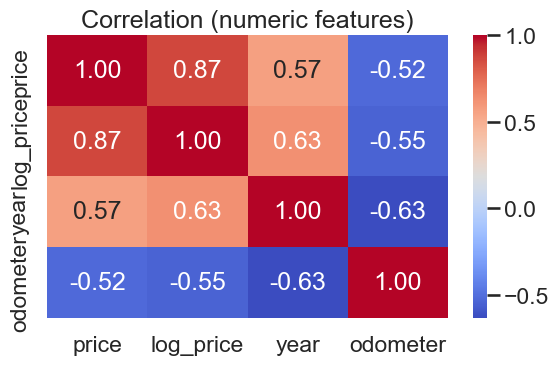

In [12]:
num_cols = [c for c in ["price", "log_price", "year", "odometer"] if c in df_clean.columns]
corr = df_clean[num_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (numeric features)")
plt.tight_layout()
plt.show()


## 4) Modeling (multiple regression models + CV + GridSearchCV)

In [13]:
# Choose columns (drop IDs/text/high-leak fields if present)
drop_cols = [c for c in ["id", "vin", "VIN", "url", "image_url", "description", "posting_date",
                         "region", "model", "lat", "long"] if c in df_clean.columns]

target = "price"
X = df_clean.drop(columns=drop_cols + [target, "log_price"], errors="ignore")
y = df_clean[target].copy()

# Identify numeric/categorical columns
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Numeric features: ['year', 'odometer']
Categorical features: ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']


### 4.1 Helper: evaluation on holdout

In [24]:
def eval_on_holdout(model, X_test, y_test, label="model"):
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{label} | RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R²: {r2:.3f}")
    return rmse, mae, r2


### 4.2 Model A: Linear Regression (baseline)

In [23]:
lin = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log1p, inverse_func=np.expm1
    ))
])

lin.fit(X_train, y_train)
eval_on_holdout(lin, X_test, y_test, "LinearRegression (log-target)")


LinearRegression (log-target) | RMSE: 9,626.21 | MAE: 5,870.60 | R²: 0.581


(9626.205585733527, 5870.600618798851, 0.5807649147721712)

### 4.3 Cross-validation (required)

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}

cv_results = cross_validate(lin, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("CV RMSE:", (-cv_results["test_rmse"]).mean(), "±", (-cv_results["test_rmse"]).std())
print("CV MAE :", (-cv_results["test_mae"]).mean(), "±", (-cv_results["test_mae"]).std())
print("CV R²  :", (cv_results["test_r2"]).mean(), "±", (cv_results["test_r2"]).std())


CV RMSE: 9683.037930314687 ± 43.44150123734265
CV MAE : 5875.786140200447 ± 17.468368831948787
CV R²  : 0.5759953739347041 ± 0.00445792154687668


### 4.4 Model B: Ridge Regression + GridSearchCV (required hyperparameter tuning)

In [17]:
ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=Ridge(random_state=42),
        func=np.log1p, inverse_func=np.expm1
    ))
])

param_grid = {
    "model__regressor__alpha": [0.1, 1, 10, 50, 100]
}

grid = GridSearchCV(
    ridge_pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

best_ridge = grid.best_estimator_
eval_on_holdout(best_ridge, X_test, y_test, "Ridge (best, log-target)")


Best params: {'model__regressor__alpha': 0.1}
Best CV RMSE: 13087.032037892151
Ridge (best, log-target) | RMSE: 13,025.03 | MAE: 8,620.77 | R²: 0.232


(13025.031232789403, 8620.770347861087, 0.23245313437917858)

### 4.5 Model C: ElasticNet + GridSearchCV (another regression model)

In [18]:
enet_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=ElasticNet(random_state=42, max_iter=5000),
        func=np.log1p, inverse_func=np.expm1
    ))
])

enet_grid = GridSearchCV(
    enet_pipe,
    param_grid={
        "model__regressor__alpha": [0.001, 0.01, 0.1, 1.0],
        "model__regressor__l1_ratio": [0.2, 0.5, 0.8]
    },
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

enet_grid.fit(X_train, y_train)
print("Best params:", enet_grid.best_params_)
print("Best CV RMSE:", -enet_grid.best_score_)

best_enet = enet_grid.best_estimator_
eval_on_holdout(best_enet, X_test, y_test, "ElasticNet (best, log-target)")


Best params: {'model__regressor__alpha': 0.001, 'model__regressor__l1_ratio': 0.2}
Best CV RMSE: 9124.636090717433
ElasticNet (best, log-target) | RMSE: 9,060.45 | MAE: 5,295.64 | R²: 0.629


(9060.451573589655, 5295.643261068289, 0.628595601473934)

## 5) Coefficient Interpretation (required)

In [19]:
def get_feature_names(preprocess, numeric_features, categorical_features):
    num_names = numeric_features
    ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    return np.array(num_names + cat_names, dtype=object)

def show_top_coefficients(fitted_pipeline, top_n=20):
    preprocess_fitted = fitted_pipeline.named_steps["preprocess"]
    ttr = fitted_pipeline.named_steps["model"]
    reg = ttr.regressor_

    feature_names = get_feature_names(preprocess_fitted, numeric_features, categorical_features)
    coefs = reg.coef_.ravel()

    coef_df = pd.DataFrame({"feature": feature_names, "coef_log": coefs})
    coef_df["approx_%_change"] = (np.exp(coef_df["coef_log"]) - 1) * 100

    print("Top positive drivers (higher predicted price):")
    display(coef_df.sort_values("coef_log", ascending=False).head(top_n))

    print("Top negative drivers (lower predicted price):")
    display(coef_df.sort_values("coef_log", ascending=True).head(top_n))

    return coef_df

coef_df = show_top_coefficients(best_ridge, top_n=15)


Top positive drivers (higher predicted price):


,feature,coef_log,approx_%_change
0,year,7.994641e-10,7.994641e-08
70,transmission_other,2.535225e-11,2.535216e-09
45,condition_good,1.591510e-11,1.591505e-09
71,drive_4wd,1.531069e-11,1.531064e-09
86,type_pickup,1.486930e-11,1.486922e-09
75,size_full-size,1.393159e-11,1.393152e-09
57,fuel_diesel,1.091900e-11,1.091904e-09
55,cylinders_8 cylinders,1.071390e-11,1.071387e-09
61,fuel_other,1.050064e-11,1.050071e-09
54,cylinders_6 cylinders,9.393382e-12,9.393375e-10


Top negative drivers (lower predicted price):


,feature,coef_log,approx_%_change
1,odometer,-7.656784e-06,-7.656755e-04
87,type_sedan,-2.700141e-11,-2.700140e-09
59,fuel_gas,-2.146595e-11,-2.146594e-09
68,transmission_automatic,-2.126578e-11,-2.126577e-09
72,drive_fwd,-2.083890e-11,-2.083889e-09
52,cylinders_4 cylinders,-1.943021e-11,-1.943024e-09
43,condition_excellent,-9.499106e-12,-9.499068e-10
76,size_mid-size,-8.449053e-12,-8.449019e-10
44,condition_fair,-5.919499e-12,-5.919487e-10
17,manufacturer_honda,-5.545613e-12,-5.545564e-10


## 6) Residual diagnostics (Evaluation add-on)

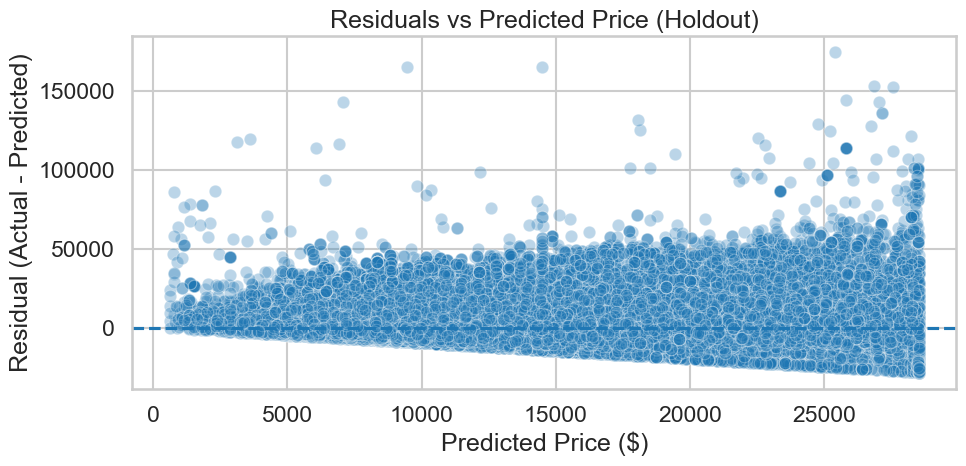

In [20]:
preds = best_ridge.predict(X_test)
resid = y_test - preds

plt.figure(figsize=(10, 5))
sns.scatterplot(x=preds, y=resid, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predicted Price (Holdout)")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


## 7) Summary tables for report (median price by key segments)

In [21]:
def median_price_table(df, group_col, top_n=15):
    tmp = df.dropna(subset=[group_col]).copy()
    summary = (tmp.groupby(group_col)["price"]
               .agg(count="size", median="median", mean="mean")
               .sort_values("median", ascending=False)
               .head(top_n))
    return summary

for col in ["drive", "fuel", "type", "condition", "title_status", "transmission", "manufacturer"]:
    if col in df_clean.columns:
        print(f"\n=== {col} ===")
        display(median_price_table(df_clean, col, top_n=12))



=== drive ===


,count,median,mean
drive,,,
4wd,115568,20999.0,24089.478930
rwd,48572,19998.0,21825.844355
fwd,94623,10640.0,12861.003921



=== fuel ===


,count,median,mean
fuel,,,
diesel,25051,32952.0,34403.139994
other,27238,27990.0,28555.750789
electric,1584,25990.0,26296.726010
gas,309882,13995.0,17351.425827
hybrid,4750,12995.0,15822.192211



=== type ===


,count,median,mean
type,,,
pickup,39869,28590.0,28926.305275
other,19321,27990.0,27944.979866
truck,28898,26000.0,28120.827808
coupe,15927,21590.0,23764.946945
van,7622,16950.0,18819.163212
convertible,6238,16700.0,20771.953831
SUV,68022,14995.0,18007.063362
hatchback,15470,14990.0,15315.712153
offroad,452,13900.0,17442.269912



=== condition ===


,count,median,mean
condition,,,
new,962,22991.5,30281.397089
good,114617,21590.0,21383.130897
like new,19042,14950.0,19344.766411
excellent,89569,11995.0,15636.488975
fair,5420,2500.0,3778.903506
salvage,471,2000.0,4074.271762



=== title_status ===


,count,median,mean
title_status,,,
lien,1377,18000.0,22401.843137
clean,351829,16000.0,19638.162832
rebuilt,6884,10495.0,12810.785590
salvage,3680,7500.0,9788.433152
missing,271,2000.0,3813.350554
parts only,103,1500.0,3625.786408



=== transmission ===


,count,median,mean
transmission,,,
other,60419,28590.0,28436.697562
automatic,290305,13351.0,17740.270877
manual,18356,10000.0,14919.211865



=== manufacturer ===


,count,median,mean
manufacturer,,,
ferrari,61,98900.0,103404.163934
aston-martin,21,52000.0,61136.619048
tesla,836,37990.0,39819.269139
ram,16092,29998.0,30490.225951
porsche,1179,29997.0,33457.842239
alfa-romeo,834,29695.0,29983.887290
jaguar,1809,28990.0,27835.977336
rover,1904,25995.0,29574.570903
audi,7009,24990.0,25462.362819
